In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Enable memory growth for GPUs to avoid out-of-memory errors
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

    tf.config.experimental.set_memory_growth(device, True)


In [ ]:
# Load the MNIST dataset
(x_train_, y_train_), (x_test_, y_test_) = keras.datasets.mnist.load_data()

# Filter out digit '6' from the training and test sets
train_mask = y_train_ != 6
test_mask = y_test_ != 6

x_train, y_train = x_train_[train_mask], y_train_[train_mask]
x_test, y_test = x_test_[test_mask], y_test_[test_mask]

# Normalize the data to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the data
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)



11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
input_shape = x_train.shape[1]
latent_dim = 2  # Dimension of the latent space

# Encoder
encoder_inputs = keras.Input(shape=(input_shape,))
x = layers.Dense(512, activation='relu')(encoder_inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(lambda x: sampling(x[0], x[1]))([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
decoder_outputs = layers.Dense(input_shape, activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# VAE Model
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name='vae')

# Loss Function
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(encoder_inputs, outputs))
reconstruction_loss *= input_shape

kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5

vae_loss = reconstruction_loss + kl_loss
vae.add_loss(vae_loss)
vae.compile(optimizer=keras.optimizers.Adam())



In [ ]:
vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))


Epoch 1/50
423/423 [==============================] - 7s 6ms/step - loss: 182.7650 - val_loss: 157.8427
Epoch 2/50
423/423 [==============================] - 2s 5ms/step - loss: 154.6693 - val_loss: 150.9836
Epoch 3/50
423/423 [==============================] - 2s 5ms/step - loss: 150.0213 - val_loss: 148.1774
Epoch 4/50
423/423 [==============================] - 2s 5ms/step - loss: 147.3197 - val_loss: 146.7272
Epoch 5/50
423/423 [==============================] - 2s 5ms/step - loss: 145.4925 - val_loss: 143.9366
Epoch 6/50
423/423 [==============================] - 2s 5ms/step - loss: 143.6047 - val_loss: 141.8947
Epoch 7/50
423/423 [==============================] - 2s 5ms/step - loss: 142.4047 - val_loss: 141.3012
Epoch 8/50
423/423 [==============================] - 2s 5ms/step - loss: 141.4004 - val_loss: 140.2376
Epoch 9/50
423/423 [==============================] - 2s 5ms/step - loss: 140.5026 - val_loss: 139.6895
Epoch 10/50
423/423 [==============================] - 2s 5ms/st

In [ ]:
# Select some '6' images as anomalies
(x_anomaly, _) = x_test_[y_test_ == 6], y_test_[y_test_ == 6]

x_anomaly = x_anomaly.astype('float32') / 255.0
x_anomaly = x_anomaly.reshape(-1, 28 * 28)

# Compute reconstruction loss for normal and anomaly data
reconstructed = vae.predict(x_test)
reconstruction_loss_normal = np.mean(np.abs(reconstructed - x_test), axis=1)

reconstructed_anomaly = vae.predict(x_anomaly)
reconstruction_loss_anomaly = np.mean(np.abs(reconstructed_anomaly - x_anomaly), axis=1)

# Threshold for anomaly detection
threshold = np.percentile(reconstruction_loss_normal, 95)

# Predict anomalies
y_pred_normal = reconstruction_loss_normal > threshold
y_pred_anomaly = reconstruction_loss_anomaly > threshold

# Create labels for evaluation
y_true_normal = np.zeros_like(y_pred_normal)
y_true_anomaly = np.ones_like(y_pred_anomaly)

y_true = np.concatenate([y_true_normal, y_true_anomaly])
y_pred = np.concatenate([y_pred_normal, y_pred_anomaly])

# Calculate scores
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


30/30 [==============================] - 0s 2ms/step
Accuracy: 0.9258
Precision: 0.5962566844919787
Recall: 0.6983298538622129
F1 Score: 0.6432692307692307


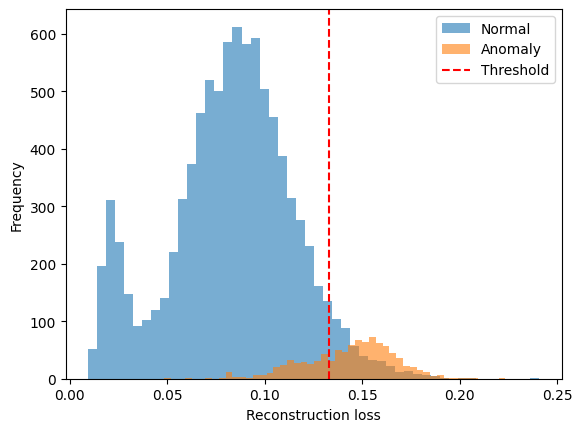

In [ ]:
# Plot the reconstruction losses
plt.hist(reconstruction_loss_normal, bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_loss_anomaly, bins=50, alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel('Reconstruction loss')
plt.ylabel('Frequency')
plt.show()
